<center><b>EE 538 Spring 2021<br>
Low-Noise Analog Circuit Design<br>
University of Washington Electrical & Computer Engineering</b></center>


<b>Instructor: Jason Silver<br>
Assignment #2 (10 points)<br>
Due Sunday, April 18 (Submit on Canvas as a Jupyter Notebook)</b> 

*Please show your work*

In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator

In [2]:
def read_ltspice(file_name,ftype='trans',units='db'):
    cols = []
    arrs = []
    with open(file_name, 'r',encoding='utf-8') as data:
        for i,line in enumerate(data):
            if i==0:
                cols = line.split()
                arrs = [[] for _ in cols]
                continue
            parts = line.split()
            for j,part in enumerate(parts):
                arrs[j].append(part)
    df = pd.DataFrame(arrs,dtype='float64')
    df = df.T
    df.columns = cols
    if ftype=='trans':
        return df
    elif ftype=='ac':
        if units=='db':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Mag_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].apply(lambda x: x[1:-2])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].astype('float64')
                    df[f'Phase_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].apply(lambda x: x[0:-2])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].astype('float64')
        if units=='cartesian':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Re_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Re_{col}'] = df[f'Re_{col}'].astype('float64')
                    df[f'Im_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Im_{col}'] = df[f'Im_{col}'].astype('float64')
        df['Freq.'] = df['Freq.'].astype('float64')
        return df
    else:
        print('invalid ftype')

In [3]:
def rnd(num,places,unit):
    if unit.lower()=='mhz':
        return round(num/(1e6),places)

<b>Problem 1: Photodiode amplifier design

Transimpedance amplifiers (TIAs) are frequently used as current-input amplifiers, wherein a feedback resistance $R_f$ determines the TIA gain. Unfortunately, $R_f$ forms a pole with both the photodiode capacitance and the input capacitance of the opamp, degrading phase margin and leading to peaking in the closed-loop amplifier response.

<center><img src="img/HW2_TIA.png" width=400 /></center>
<br>
<center><b>Figure 1. Current-input amplifier (TIA)</center>

<u>*Analysis*</u>

The closed-loop transfer function of the uncompensated ($C_f = 0$) TIA can be expressed as

\begin{equation}
\dfrac{V_{out}}{i_{in}} = R_f\cdot \dfrac{A_{ol}(f)}{1+A_{ol}(f)+sC_{in}R_f}
\end{equation}

__a)__ Determine an expression for the closed-loop transfer function of the compensated TIA (including $C_f$) assuming an opamp with a first-order response ($A_{ol}(f) = A_0/(1+s/s_p)$, where $A_0$ is the DC gain of the opamp). What is the closed-loop resonant frequency ($\omega_0$) of the TIA in terms of $R_f$, $C_f$, $C_{in}$ and $\omega_u$?

$\begin{eqnarray}
&& |s_p| &=& \omega_p &= \omega_0 \\[0.5em] 
&& \omega_u &=& A_0 \omega_p \\[0.5em]
&& C_{in} &\gg& C_f  & \text{so } C_f + C_{in} \approx C_{in} \\[0.5em]
\end{eqnarray}$

$\begin{eqnarray}
1.&& \\[0.5em]
&& A_{OL}(f) &=& \frac{A_0}{1+\frac{s}{s_p}} \\[0.5em]
2.&& \\[0.5em]
&& V_{out} &=& (V^+-V^-) \cdot A_{OL}(f)\Bigg|_{V^+=0} = -V^- \cdot A_{OL}(f)  \\[0.5em]
3.&& \\[0.5em]
&& Z_f &=& R_f \parallel C_f \\[0.5em]
&& &=& (\frac{1}{R_f}+  sC_f)^{-1} \\[0.5em]
&& &=& \frac{R_f}{1+sR_f C_f} \\[0.5em]
4.&& \\[0.5em]
&& i_{in} &=& \frac{V^-}{Z_{in}} + \frac{V^- - V_{out}}{Z_f} \\[0.5em]
&& &=& V^- sC_{in} + (V^- - V_{out})(\frac{1}{R_f} + sC_f) \\[0.5em]
&& &=& V^-(sC_{in} + \frac{1}{R_f} + sC_f) - V_{out}(\frac{1}{R_f} + sC_f) \\[0.5em]
&& &=& V^-(1 + \frac{sR_f(C_{in}+C_f)}{R_f}) - V_{out}(\frac{1+sR_f C_f}{R_f}) \\[0.5em]
&& &=& \frac{- V_{out}}{A_{OL}(f)}(1 + \frac{sR_f(C_{in}+C_f)}{R_f}) - V_{out}(\frac{1+sR_f C_f}{R_f}) \\[0.5em]
&& &=& \frac{- V_{out}}{A_{OL}(f) R_f}(1 + sR_f(C_{in}+C_f)) - \frac{V_{out}}{R_f}(1+sR_f C_f) \\[0.5em]
&& &=& \frac{- V_{out}}{A_{OL}(f) R_f}(1 + sR_f(C_{in}+C_f)) - \frac{V_{out}}{A_{OL}(f) R_f}A_{OL}(f)(1+sR_f C_f) \\[0.5em]
\end{eqnarray}$

$\begin{eqnarray}
5.&& \\[0.5em]
&& \frac{V_{out}}{i_{in}} &=& \frac{-A_{OL}(f) R_f}{1 + sR_f(C_{in}+C_f)+ A_{OL}(f)(1+sR_f C_f)} \\[0.5em]
&& \frac{V_{out}}{i_{in}} &=& \frac{-A_{OL}(f) R_f}{1 + sR_f C_{in}+ A_{OL}(f)(1+sR_f C_f)} \\[0.5em]
&& &=& \frac{-\frac{A_0}{1+\frac{s}{s_p}} R_f}{1 + sR_f C_{in}+ \frac{A_0}{1+\frac{s}{s_p}}(1+sR_f C_f)} \\[0.5em]
&& &=& \frac{-A_0 R_f}{(1+\frac{s}{s_p})(1 + sR_f C_{in}) + \frac{A_0}{1+\frac{s}{s_p}}(1+sR_f C_f))} \\[0.5em]
&& &=& \frac{-A_0 R_f}{(1+\frac{s}{s_p})(1 + sR_f C_{in})+ A_0(1+sR_f C_f)} \\[0.5em]
&& &=& \frac{-A_0 R_f}{1+sR_f C_{in}+\frac{s}{s_p}+\frac{s^2}{s_p} R_f C_{in}+A_0+s A_0 R_f C_f} \\[0.5em]
&& &=& \frac{-A_0 R_f}{(1+A_0)+s(\frac{1}{s_p}+R_f C_{in}+ A_0 R_f C_f)+\frac{s^2}{s_p} R_f C_{in}} \\[0.5em]
&& &\approx& \frac{-R_f}{1+s(\frac{1}{A_0 s_p}+\frac{R_f C_{in}}{A_0}+R_f C_f)+\frac{s^2}{A_0 s_p} R_f C_{in}} \\[0.5em]
&& &\approx& \frac{-R_f}{1+s R_f C_f+\frac{s^2}{A_0 s_p} R_f C_{in}} \\[0.5em]
&& &\approx& \frac{-R_f}{1+s R_f C_f+\frac{s^2}{\omega_u} R_f C_{in}} \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& H(s)  &=& {\frac {\omega _{0}^{2}}{s^{2}+2\zeta \omega _{0}\cdot s+\omega _{0}^{2}}} \\[0.5em]
&&       &=& {\frac {\omega _{0}^{2}}{s^{2}+\frac{s\cdot\omega_0}{Q}+\omega _{0}^{2}}} \\[0.5em]
&&       &=& {\frac {1}{\frac{s^{2}}{\omega_0^2}+\frac{s\cdot\omega_0}{Q}+1}}  \\[0.5em]
&& \frac{V_{out}}{i_{in}} &\approx& -R_f \frac{1}{1 + s R_f C_f + \frac{s^2}{\omega_u}R_f  C_{in}} \\[0.5em]
&& \frac{1}{\omega_0^2} &=& \frac{R_f  C_{in}}{\omega_u} \\[0.5em]
&& \omega_0^2 &=& \frac{\omega_u}{R_f  C_{in}} \\[0.5em]
&& \omega_0 &=& \sqrt{\frac{\omega_u}{R_f  C_{in}}} \\[0.5em]
\end{eqnarray}$

<hr>

__b)__ Show that choosing $C_f$ such that $\dfrac{1}{R_fC_f} \approx \sqrt{\dfrac{\omega_u}{2R_fC_{in}}}$ (assuming $C_{in} >> C_f$) results in a maximally flat (i.e. Butterworth) response. 

$\begin{eqnarray}
&& H(s)  &=& {\frac {1}{\frac{s^{2}}{\omega_0^2}+\frac{s}{Q\omega_0}+1}}  \\[0.5em]
&& \omega_0 &=& \sqrt{\frac{\omega_u}{R_f C_{in}}} \\[0.5em]
&& \frac{V_{out}}{i_{in}} &\approx& -R_f \frac{1}{1 + s R_f C_f + \frac{s^2}{\omega_u}R_f  C_{in}} \\[0.5em]
&& \frac{V_{out}}{i_{in}} &\approx& -R_f \frac{1}{1 + s R_f C_f + \frac{s^2}{\omega_0^2}}  &\text{and Butterworth }& Q=\frac{1}{\sqrt2}\\[0.5em]
&& \text{then} && R_f C_f = \frac{1}{Q\omega_0} = \frac{\sqrt{2}}{\omega_0}\\[0.5em]
&& \sqrt{2} &=& \sqrt{\frac{\omega_u}{R_f C_{in}}} R_f C_f \\[0.5em]
&& R_f C_f &=& \frac{\sqrt{2}}{\sqrt{\frac{\omega_u}{R_f C_{in}}}} \\[0.5em]
&& &=& \sqrt{2} \sqrt{\frac{R_f C_{in}}{\omega_u}} \\[0.5em]
&& &=& \sqrt{\frac{2 R_f C_{in}}{\omega_u}} \\[0.5em]
&& \frac{1}{R_f C_f} &=& \sqrt{\frac{\omega_u}{2 R_f C_{in}}} \\[0.5em]
&& C_f &=& \frac{1}{R_f} \sqrt{\frac{2 R_f C_{in}}{\omega_u}} \\[0.5em]
&&  &=& \sqrt{\frac{2 C_{in}}{R_f \omega_u}} \\[0.5em]
&&  &=& \sqrt{\frac{2 C_{in}}{R_f A_0 \omega_p}} \\[0.5em]
&&  &=& \sqrt{\frac{2 C_{in}}{2 \pi R_f A_0 f_p}} \\[0.5em]
&& C_f &=& \sqrt{\frac{C_{in}}{\pi R_f A_0 f_p}} \\[0.5em]
\end{eqnarray}$

<u>*Design*</u>

__c)__ Design the TIA in Figure 1 for a gain of $10k\Omega$ and a Butterworth response with a $3dB$ bandwidth of $2MHz$. Assuming $C_{in}$ = $100pF$, what are the required values of $\omega_u$ (opamp GBW) and $C_f$? Verify your design in Ltspice.

<img src="img/setup.PNG" width="700">

$\begin{eqnarray}
1. && && \\[0.5em]
& H(s) &  &=& {\frac {\omega _{0}^{2}}{s^{2}+2\zeta \omega _{0}\cdot s+\omega _{0}^{2}}} \\[0.5em]
&&       &=& {\frac {1}{\frac{s^{2}}{\omega_0^2}+\frac{s}{Q\omega_0}+1}}  &\text{and Butterworth } Q=\frac{1}{\sqrt2} \\[0.5em]
& |H(s)| & &=& {\frac {1}{\sqrt{1+\frac{\omega^4}{\omega_0^4}}}} \\[0.5em]
& \frac{1}{\sqrt{2}} & &=& {\frac {1}{\sqrt{1+\frac{\omega^4}{\omega_0^4}}}} \\[0.5em]
2. && && \\[0.5em]
& \omega_{3dB_{CL}} & &=& \omega_0 \\[0.5em]
& \omega_{3dB_{CL}}& &=& \sqrt{\frac{\omega_u}{R_f  C_{in}}} \\[0.5em]
&& &=& \sqrt{\frac{A_0 \omega_p}{R_f  C_{in}}} \\[0.5em]
&& &=& \sqrt{\frac{2 \pi A_0 \cdot f_{3dB_{OL}}}{R_f  C_{in}}} \\[0.5em]
3. && && \\[0.5em]
& 2\pi f_{3dB_{CL}} & &=& \sqrt{\frac{2 \pi A_0 \cdot f_{3dB_{OL}}}{R_f  C_{in}}} \\[0.5em]
& f_{3dB_{CL}} & &=& \sqrt{\frac{A_0 \cdot f_{3dB_{OL}}}{2\pi R_f  C_{in}}} & \text{and similarly} \\[0.5em]
4. && && \\[0.5em]
& f_{3dB_{OL}} & &=& 2\pi (f_{3dB_{CL}})^2 C_{in} \Bigg|_{A_0 = R_f} \\[0.5em]
& \omega_u &  &=& A_0 \omega_p \\[0.5em]
& \omega_u & &=& A_0 \cdot  2\pi f_{3dB_{OL}} \\[0.5em]
\end{eqnarray}$

<hr>

In [4]:
f3dbCL = 2*1e6
R_f = 10*1e3
C_in = 100*1e-12
A_0 = R_f
f3dbOL = 2*np.pi * f3dbCL**2 * C_in * R_f/A_0
omega_p = f3dbOL*2*np.pi
omega_u = A_0*omega_p  # gain bandwidth
omega_0 = np.sqrt(omega_u/(R_f*C_in))
C_f = sp.sqrt(2*C_in/(R_f*omega_u))

print(f'omega_u = {rnd(omega_u,2,"MHz")} MHz')
print(f'omega_0 = {rnd(omega_0,2,"MHz")} MHz')
print(f'C_f = {C_f} F')

omega_u = 157.91 MHz
omega_0 = 12.57 MHz
C_f = 1.12539539519638E-11 F


#### Calculated

In [5]:
s,R_f,C_f,C_in,A_0,omega_p,omega_0,omega_u,f3db = sp.symbols('s,R_f,C_f,C_in,A_0,omega_p,omega_0,omega_u,f3db')
f = np.logspace(4, 7, 100000)
w = 2*np.pi*f

num = R_f
den = (R_f*C_in/(omega_u))*s**2 + (R_f*C_f)*s + 1

components = {
    R_f : 10*1e3,
    C_in: 100*1e-12,
    C_f : 1.1254e-11,
    omega_u: 157.91*1e6,
}
H = sp.Matrix([num/den])
H1 = H = H.subs(components)
H = lambdify(s,H,modules='numpy')
H = H(1j*w)
H = H[0][0]

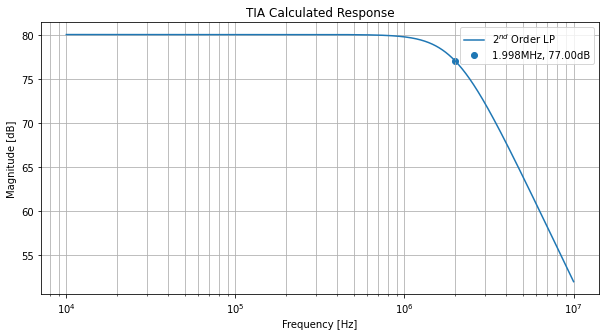

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

x1 = np.where(20*np.log10(abs(H))<=max(20*np.log10(abs(H)))-3)[0][0]
label1 = "{:.3f}MHz, {:.2f}dB".format(rnd(f[x1],3,"MHz"), 20*np.log10(abs(H[x1])))

ax.set_title('TIA Calculated Response')
ax.semilogx(f, 20*np.log10(abs(H)),label=r'$2^{nd}$ Order LP')
ax.scatter(f[x1],20*np.log10(abs(H[x1])),label=label1,color='tab:blue')
ax.set_ylabel('Magnitude [dB]')
ax.set_xlabel('Frequency [Hz]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

#### LTspice

In [7]:
filepath = 'data/HW02.txt'
df = read_ltspice(filepath,'ac')
freq = df['Freq.']
mag = df['Mag_V(vout)/I(Iin)']

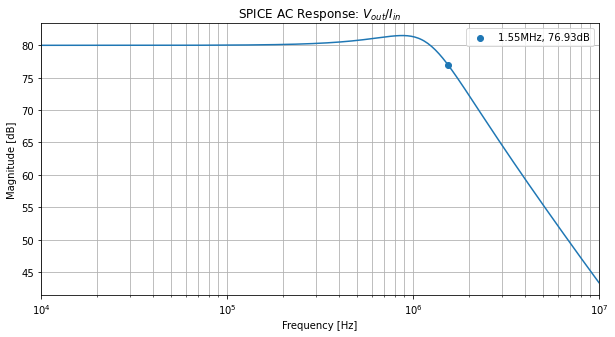

In [8]:
fig, ax = plt.subplots(1,figsize=(10,5))

x1 = np.where(mag<=mag[0]-3)[0][0]
label1 = "{:.2f}MHz, {:.2f}dB".format(rnd(freq[x1],2,"MHz"), mag[x1])

ax.semilogx(freq, mag, color='tab:blue',label='')
ax.scatter(freq[x1],mag[x1],label=label1,color='tab:blue')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude [dB]')
ax.set_title(r'SPICE AC Response: $V_{out}/I_{in}$')
ax.set_xlim(1e4,1e7)

ax.legend()
plt.show();

__d)__ Assuming an opamp with $e_{na} = 5 nV/\sqrt{Hz}$ and $i_{na} = 0$, determine an expression for the mean-squre input-referred noise current density $i_n^2$ of the TIA as a function of frequency (ignore bandwidth limitations of the TIA). Taking the TIA bandwidth into account, what is the maximum value of $i_n$? At what frequency do we see the maximum noise density? Verify in Ltspice.

Maximum noise density occurs at the 3dB cutoff frequency..

$\begin{eqnarray}
&& i_{na} &=& 0 \\[0.5em]
&& e_{na} &=& 5 nV/\sqrt{Hz} \\[0.5em]
&& i_{nC} &=& e_{na} \cdot 2\pi f C_{in} = \frac{5 nV}{\sqrt{Hz}} \cdot 2\pi f \cdot 100\text{pf} \\[0.5em]
&& i_{sh}^2 &=& 2qI_D\Delta f  \\[0.5em]
&& i_n(f) &=& \sqrt{(i_{sh})^2 + (\frac{e_{na}}{R_f})^2 + (\frac{\sqrt{4kTR_f}}{R_f})^2 + (i_{nC})^2} \\[0.5em]
&&  &=& \sqrt{(2qI_D) \Delta f + (\frac{e_{na}}{R_f})^2 + (\frac{\sqrt{4kTR_f}}{R_f})^2 + (e_{na} \cdot 2\pi f C_{in})^2} \\[0.5em]
&&  &=& \sqrt{(2qI_D) \Delta f + (\frac{e_{na}}{R_f})^2 + (\frac{4kT}{R_f}) + (e_{na} \cdot 2\pi f C_{in})^2} \\[0.5em]
&& i_n(f)^2 &=& (2qI_D) \Delta f + (\frac{e_{na}}{R_f})^2 + (\frac{4kT}{R_f}) + (e_{na} \cdot 2\pi f C_{in})^2 \Bigg|_{f = f_{3dB}} \\[0.5em]
\end{eqnarray}$

<hr>

In [9]:
# fig, ax = plt.subplots(figsize=(10,5))

# ax.set_title('TIA Calculated Response')
# ax.semilogx(f, 20*np.log10(abs(H)),label=r'$2^{nd}$ Order LP')
# ax.scatter(f[x1],20*np.log10(abs(H[x1])),label=label1,color='tab:blue')
# ax.set_ylabel('Magnitude [dB]')
# ax.set_xlabel('Frequency [Hz]')
# ax.grid(which='both', axis='both')
# ax.legend()
# plt.show();

#### LTspice

In [10]:
filepath = 'data/HW02_noise.txt'
df = pd.read_csv(filepath)
freq = df['frequency']
mag = df['V(onoise)']

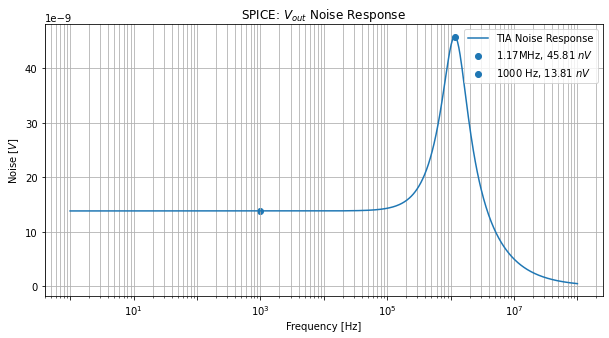

In [11]:
fig, ax = plt.subplots(1,figsize=(10,5))

x1 = np.where(freq<=1000)[0][-1]
label1 = r"1000 Hz, {:.2f} $nV$".format(mag[x1]*1e9)

x2 = mag.idxmax()
label2 =  r"{:.2f}MHz, {:.2f} $nV$".format(rnd(freq[x2],2,"MHz"),mag[x2]*1e9)

ax.semilogx(freq, mag, color='tab:blue',label='TIA Noise Response')
ax.scatter(freq[x2],mag[x2],label=label2,color='tab:blue')
ax.scatter(freq[x1],mag[x1],label=label1,color='tab:blue')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Noise $[V]$')
ax.set_title(r'SPICE: $V_{out}$ Noise Response')
ax.ticklabel_format(style='sci', axis='y', scilimits=(-9,-9))
#ax.set_ylim(10e-9,50e-9)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.legend()
plt.show();

__e)__ If the TIA is driven by a photodiode with a DC current of $10\mu A$, what is the noise figure of the amplifier, in terms of noise density, at $1kHz$?

Maximum noise density occurs at the 3dB cutoff frequency..

$\begin{eqnarray}
& \text{NF} & &=& 10\log{F} \\[0.5em]
& F & &\equiv& \dfrac{\text{total output noise power}}{\text{output noise due to input source}} \\[0.5em]
& \text{total output noise power} & &=& (2qI_D) \Delta f + (\frac{e_{na}}{R_f})^2 + (\frac{4kT}{R_f}) + (e_{na} \cdot 2\pi f C_{in})^2 \\[0.5em]
& \text{input source noise power} & &=& (2qI_D) \\[0.5em]
\end{eqnarray}$

<hr>

In [12]:
T = 298
k = 1.381 * 1e-23
q = 1.38 * 1e-23
I_D = 10*1e-6
f = 1000
e_na = 5*1e-9
Rf = 10*1e3
Cin = 100*1e-12

shot = (2*q*I_D)
amp = (e_na/Rf)**2
therm =  4*k*T/Rf
cap = (e_na *2*np.pi*f*Cin)**2


total_output = shot + amp + therm + cap
input_source = shot

NF = 10* np.log10(total_output/input_source)
print(f'Noise Figure = {round(NF,2)}')

Noise Figure = 38.37


### Refence Page

Resources:


https://www.analog.com/en/analog-dialogue/articles/compensating-current-feedback-amplifiers.html

https://www.analog.com/en/technical-articles/transimpedance-amplifier-noise-considerations.html

https://e2e.ti.com/support/amplifiers/f/amplifiers-forum/379953/open-loop-gain-vs-closed-loop-gain-in-tia

https://www.allaboutcircuits.com/technical-articles/negative-feedback-part-8-analyzing-transimpedance-amplifier-stability/

https://www.embeddedcomputing.com/technology/analog-and-power/batteries-power-supplies/tia-fundamentals-the-noise-transfer-function-part-4

https://www.tij.co.jp/jp/lit/an/snoa942a/snoa942a.pdf?ts=1618760264451&ref_url=https%253A%252F%252Fwww.google.com%252F

https://e2e.ti.com/support/amplifiers/f/amplifiers-forum/504360/how-to-maintain-stability-of-a-tia-when-exceeding-the-open-loop-gain

https://people.engr.tamu.edu/spalermo/ecen689_oi/lecture5_ee689_tias.pdf

https://2n3904blog.com/trans-impedance-amplifier-transfer-function/

http://www.seas.ucla.edu/brweb/papers/Journals/BR_SSCM_1_2019.pdf

https://www.ti.com/lit/an/sboa122/sboa122.pdf?ts=1618932133586

https://www.ti.com/lit/an/snoa515a/snoa515a.pdf?ts=1618912072084&ref_url=https%253A%252F%252Fwww.google.com%252F

$\begin{eqnarray}
&& \frac{V_{out}}{i_{in}} &=& \frac{Z_f A_{OL}(f)}{1 + \frac{Z_f}{Z_{C_{in}}} + A_{OL}(f)} \\[0.5em]
&&  &=& Z_f \frac{A_{OL}(f)}{1 + A_{OL}(f) + \frac{Z_f}{Z_{C_{in}}}} \\[0.5em]
&&  &=& Z_f \frac{1}{1 + \frac{1 + \frac{Z_f}{Z_{C_{in}}}}{A_{OL}(f)}} \\[0.5em]
&&  &=& Z_f \frac{1}{1 + \frac{1}{\beta A_{OL}(f)}} &
\text{where } \frac{1}{\beta} =  1 + \frac{Z_f}{Z_{C_{in}}} =1 + \frac{(1+sR_f C_f)sC_{in}}{R_f} = \frac{C_f C_{in} s^2}{R_f} + \frac{C_{in} s}{R_f} + 1\\[0.5em]
\end{eqnarray}$

In [13]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator

In [14]:
def read_ltspice(file_name,ftype='trans',units='db'):
    cols = []
    arrs = []
    with open(file_name, 'r',encoding='utf-8') as data:
        for i,line in enumerate(data):
            if i==0:
                cols = line.split()
                arrs = [[] for _ in cols]
                continue
            parts = line.split()
            for j,part in enumerate(parts):
                arrs[j].append(part)
    df = pd.DataFrame(arrs,dtype='float64')
    df = df.T
    df.columns = cols
    if ftype=='trans':
        return df
    elif ftype=='ac':
        if units=='db':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Mag_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].apply(lambda x: x[1:-2])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].astype('float64')
                    df[f'Phase_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].apply(lambda x: x[0:-2])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].astype('float64')
        if units=='cartesian':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Re_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Re_{col}'] = df[f'Re_{col}'].astype('float64')
                    df[f'Im_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Im_{col}'] = df[f'Im_{col}'].astype('float64')
        df['Freq.'] = df['Freq.'].astype('float64')
        return df
    else:
        print('invalid ftype')

In [15]:
def rnd(num,places,unit):
    if unit.lower()=='mhz':
        return round(num/(1e6),places)